# Simulation example with *thztools*

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi
from numpy.random import default_rng
from matplotlib.figure import figaspect
from scipy.signal import periodogram
from scipy.optimize import least_squares
from scipy.stats import cumfreq

from thztools.thztools import thzgen, noiseamp

## Simulate noisy terahertz time-domain waveforms

Functions from `thztools`: `thzgen`, `noiseamp`

The first cell below sets the parameters for the simulation, and the subsequent cell generates `n_sim = 11` noisy terahertz time-domain waveforms, each with `n = 256` samples, and stores them in an `(n_sim, n)` NumPy array `x`. The function `thzgen` returns discrete samples `mu` of an ideal waveform $\mu(t)$, evaluated at the measurement times `t`. The function `noiseamp` returns the noise amplitude $\sigma(t)$ at each point in the sampled waveform,  `sigma`, where
$$\sigma^2(t) = \sigma^2_\alpha + [\sigma_\beta\mu(t)]^2 + [\sigma_\tau\dot{\mu}(t)]^2$$
and $\dot{\mu}(t)$ denotes the time derivative of $\mu(t)$. We use the SciPy `periodogram` function to compute the power spectral density `psd` of the noisy sampled waveforms at the discrete frequencies `f`.

The next cell generates a figure shows (a) `mu` and `30 * sigma` and (b) the power spectral density as a function of frequency, normalized to the maximum value over all waveforms.

In [2]:
n = 256     # Number of samples
ts = 0.05   # Sampling time [ps]
t0 = 2.5    # Peak pulse time [ps]
fs = 1 / ts # Sampling frequency [THz]

sigma_alpha = 1e-4  # Additive noise amplitude [signal units]
sigma_beta = 1e-2   # Multiplicative noise amplitude [dimensionless]
sigma_tau = 1e-3    # Time base noise amplitude [ps]
sigma_parms = np.array([sigma_alpha, sigma_beta, sigma_tau])

seed = 0    # RNG seed
rng = default_rng(seed)

In [3]:
mu, t = thzgen(n, ts, t0)
sigma = noiseamp(sigma_parms, mu, ts)

# Use broadcasting to generate multiple simulated noisy measurements of y
n_sim = 11
x = mu + sigma * rng.standard_normal((n_sim, n))

# Compute power spectral density
f, psd = periodogram(x, fs=fs, detrend=False)
n_f = f.size

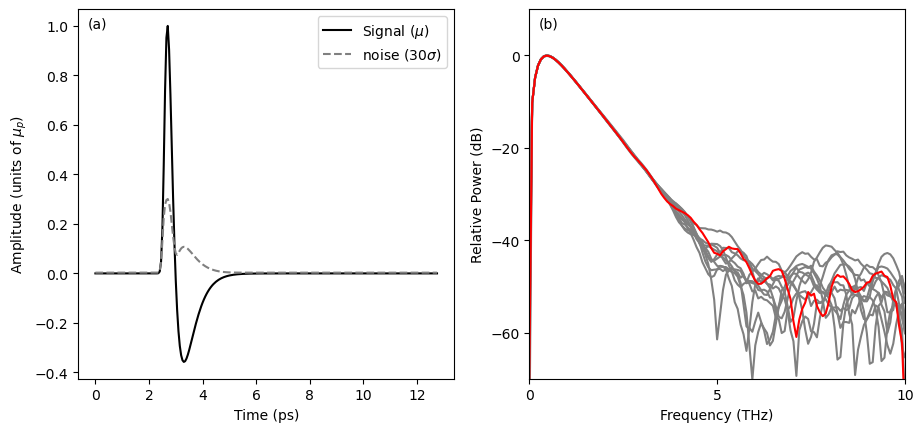

In [4]:
w, h = figaspect(0.45)
_, axs = plt.subplots(1, 2, figsize=(w, h))

axs[0].plot(t, mu, c='k', label=r'Signal ($\mu$)')
axs[0].plot(t, sigma * 30, ls='--', c='grey', label=r'noise $(30 \sigma$)')

axs[0].legend()
axs[0].text(0.025, 0.95, '(a)', transform=axs[0].transAxes)

axs[0].set_xlabel('Time (ps)')
axs[0].set_ylabel(r'Amplitude (units of $\mu_{p})$')

axs[1].plot(f, 10 * np.log10(psd[1:, :].T / max(psd.flatten())), c='grey')
axs[1].plot(f, 10 * np.log10(psd[0, :].T / max(psd.flatten())), c='red')

axs[1].text(0.025, 0.95, '(b)', transform=axs[1].transAxes)

axs[1].set_xlabel('Frequency (THz)')
axs[1].set_ylabel('Relative Power (dB)')

axs[1].set_xticks(np.arange(0, 11, 5))
axs[1].set_xlim(0, 10)
axs[1].set_yticks(np.arange(-60, 10, 20))
axs[1].set_ylim(-70, 10)

plt.show()

## Empirical transfer function estimates

In [5]:
# Clear x and n_sim for reuse
del x, n_sim

n_sim = 250
x = mu + sigma * rng.standard_normal((n_sim, n))
y = mu + sigma * rng.standard_normal((n_sim, n))

x_f = np.fft.rfft(x)
y_f = np.fft.rfft(y)
etfe = y_f / x_f

etfe_mean = np.mean(etfe, 0)

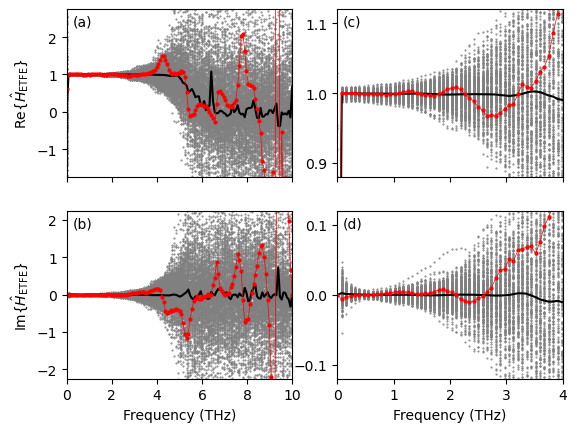

In [6]:
marker_size = 1
marker_size_highlight = 4
line_width_highlight = 0.5
_, axs = plt.subplots(2, 2, sharex='col')

axs[0, 0].plot(f, etfe.real[1:, :].T, '.',
               ms=marker_size,
               color='gray')
axs[0, 0].plot(f, etfe_mean.real, 'k-')
axs[0, 0].plot(f, etfe.real[0, :], 'r.-',
               ms=marker_size_highlight,
               lw=line_width_highlight)

axs[0, 0].text(0.025, 0.9, '(a)', transform=axs[0, 0].transAxes)

axs[1, 0].plot(f, etfe.imag[1:, :].T, '.',
               ms=marker_size,
               color='gray')
axs[1, 0].plot(f, etfe_mean.imag, 'k-')
axs[1, 0].plot(f, etfe.imag[0, :], 'r.-',
               ms=marker_size_highlight,
               lw=line_width_highlight)

axs[1, 0].text(0.025, 0.9, '(b)', transform=axs[1, 0].transAxes)

axs[0, 1].plot(f, etfe.real[1:, :].T, '.',
               ms=marker_size,
               color='gray')
axs[0, 1].plot(f, etfe_mean.real, 'k-')
axs[0, 1].plot(f, etfe.real[0, :], 'r.-',
               ms=marker_size_highlight,
               lw=line_width_highlight)

axs[0, 1].text(0.025, 0.9, '(c)', transform=axs[0, 1].transAxes)

axs[1, 1].plot(f, etfe.imag[1:, :].T, '.',
               ms=marker_size,
               color='gray')
axs[1, 1].plot(f, etfe_mean.imag, 'k-')
axs[1, 1].plot(f, etfe.imag[0, :], 'r.-',
               ms=marker_size_highlight,
               lw=line_width_highlight)

axs[1, 1].text(0.025, 0.9, '(d)', transform=axs[1, 1].transAxes)

axs[0, 0].set_ylim(-1.75, 2.75)
axs[0, 1].set_ylim(0.88, 1.12)
axs[1, 0].set_ylim(-2.25, 2.25)
axs[1, 1].set_ylim(-0.12, 0.12)

axs[0, 0].set_yticks(np.arange(-1, 3))
axs[0, 1].set_yticks(np.linspace(0.9, 1.1, 3, endpoint=True))
axs[1, 0].set_yticks(np.arange(-2, 3))
axs[1, 1].set_yticks(np.linspace(-0.1, 0.1, 3, endpoint=True))

axs[0, 0].set_ylabel(r'$\mathrm{Re}\{\hat{H}_\mathrm{ETFE}\}$')
axs[1, 0].set_ylabel(r'$\mathrm{Im}\{\hat{H}_\mathrm{ETFE}\}$')

axs[1, 0].set_xlim(0, 10)
axs[1, 1].set_xlim(0, 4)

axs[1, 0].set_xlabel('Frequency (THz)')
axs[1, 1].set_xlabel('Frequency (THz)')

plt.show()

## Fits to the empirical transfer function estimate

In [7]:
def tf_model(_p, _f):
    return _p[0] * np.exp(2 * pi * 1j * _f * _p[1])

def normres(_p, _f, _etfe, _sigma):
    _r = (_etfe - tf_model(_p, _f)) / _sigma
    return np.concatenate((_r.real, _r.imag))

sigma_etfe = np.std(etfe, axis=0)

In [51]:
p = np.empty((2, n_sim))
resnorm = np.empty((n_sim,))
residual = np.empty((n_f, n_sim), dtype=np.complex128)
for i in range(n_sim):
    result = least_squares(lambda _p: normres(_p, f, etfe[i, :], sigma_etfe), (1,0))
    p[:, i] = result.x
    residual[:, i] = result.fun[:n_f] + 1j * result.fun[n_f:]
    resnorm[i] = 4 * result.cost
    if n_f % 2 != 0:
        resnorm[i] -= np.abs(residual[-1, i]) ** 2
    if not result.success:
        print(f"Fit did not converge at i = {i}")

ecdf = cumfreq(resnorm, 250)

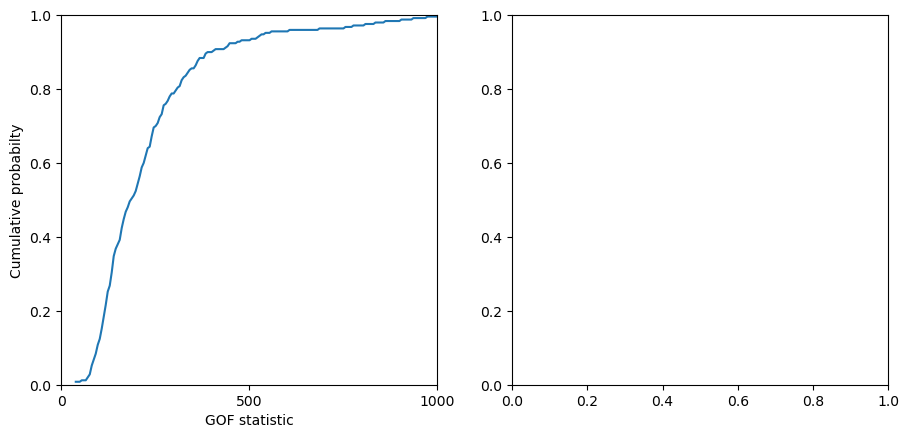

In [52]:
w, h = figaspect(0.45)
_, axs = plt.subplots(1, 2, figsize=(w, h))

axs[0].plot(ecdf.lowerlimit
            + np.linspace(0, ecdf.binsize * ecdf.cumcount.size,
                          ecdf.cumcount.size),
            ecdf.cumcount / n_sim)

axs[0].set_xlim(0, 1000)
axs[0].set_ylim(0, 1)

axs[0].set_xticks([0, 500, 1000])
axs[0].set_yticks(np.linspace(0, 1, 6, endpoint=True))

axs[0].set_xlabel('GOF statistic')
axs[0].set_ylabel('Cumulative probabilty')

plt.show()

In [53]:
i = 0
2 * np.sum(np.abs(residual[:, i]) ** 2) - np.abs(residual[-1, i]) ** 2

229.25812110401333

In [54]:
resnorm[i]

229.25812110401324